In [1]:
import numpy as np

from sklearn.metrics import confusion_matrix
from hmmlearn import hmm

import gzip
import itertools
import pickle
import time

import matplotlib.pyplot as plt
from ssm.util import find_permutation

%matplotlib inline

In [2]:
def hill_curve_001(x):
    # return 0.185 + (0.867-0.185)*x**1.18 / (68.0**1.18 + x**1.18)
    return (0.168 + (1.07-0.168)*x**0.792 / (112.0**0.792 + x**0.792)) * 100

In [3]:
def make_plots(Z, Z_hat):
    order = Z.argsort()

    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,2), sharey=True)
    ax1.imshow(Z[order].reshape(1, -1), aspect="auto", extent=(-0.5, Z.shape[0] - 0.5, 0, 1), cmap="jet")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.imshow(Z_hat[order].reshape(1, -1), aspect="auto", extent=(-0.5, Z_hat.shape[0] - 0.5, 0, 1), cmap="jet")
    ax2.set_xticks([])
    ax2.set_yticks([])
    plt.show()

    cm = confusion_matrix(Z, Z_hat)

    cm_best_ = cm.copy()
    cm_best_a_ = np.diag(cm_best_).sum()
    for p in itertools.permutations(np.arange(cm.shape[0])):
        cm_ = cm[p, :].copy()
        cm_a_ = np.diag(cm_).sum()
        if cm_a_ > cm_best_a_:
            cm_best_ = cm_.copy()
            cm_best_a_ = cm_a_
    print(cm_best_)
    print(cm_best_a_ / cm_best_.sum())

## Generating Data

In [4]:
K = 3
T = 5000

model_1 = hmm.GaussianHMM(n_components=K, covariance_type="diag")

model_1.startprob_ = np.array([0.6, 0.3, 0.1])
model_1.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.1, 0.8, 0.1],
                            [0.05, 0.05, 0.9]])
model_1.means_ = np.array([[0.0], [50.0], [100.0]])
model_1.covars_ = np.tile(np.ones(1), (K, 1))

def prep_(dat, t=7):
    X, Z = dat
    X_ = X.copy()
    X_ = X_.cumsum()
    X_ = (X_[t:] - X_[:-t])
    X = hill_curve_001(X_+10)
    X, Z = X.reshape(-1, 1), Z[t:]
    return X, Z, dat[0]

sample = [prep_(model_1.sample(T), t=3) for  _ in range(1000)]

X, Z, X_ = np.concatenate([xz[0] for xz  in sample]), np.concatenate([xz[1] for xz  in sample]), np.concatenate([xz[2] for xz  in sample])
L = [len(xz[0]) for xz in sample]

# f = gzip.open('data_hmm_004.pcklz', 'wb')
# pickle.dump(X, f)
# pickle.dump(Z, f)
# f.close()

X[np.isnan(X)] = 0.00

f = gzip.open('data_hmm_004b.pcklz', 'wb')
pickle.dump(X, f)
pickle.dump(Z, f)
f.close()

## Regular HMM

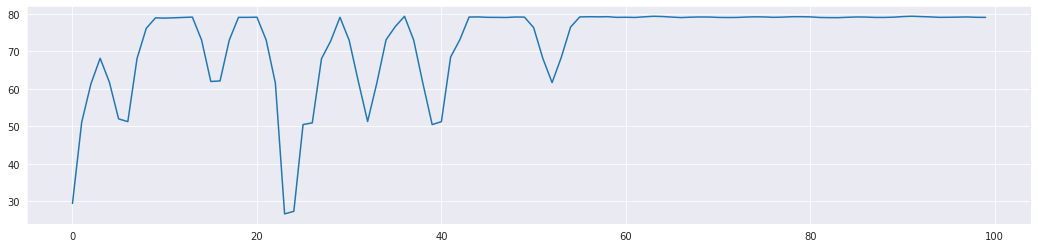

300.3378314971924


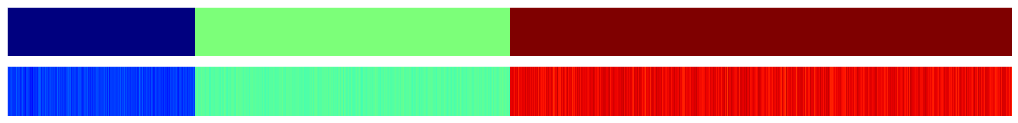

[[ 597086  339095       0]
 [ 139716 1423215       0]
 [   1633  475022 2021233]]
0.8087920752451471


In [5]:
f = gzip.open('data_hmm_004b.pcklz', 'rb')
X = pickle.load(f)
Z = pickle.load(f)
f.close()

plt.figure(figsize=(18,4))
plt.plot(X[:100])
plt.show()

model_r = hmm.GaussianHMM(n_components=K, covariance_type="diag", n_iter=20000, tol=0.0001)
t0 = time.time()
model_r = model_r.fit(X, lengths=L)
print(time.time() - t0)
Z_hat_hmmlearn = model_r.predict(X)

perm = find_permutation(Z_hat_hmmlearn, Z)
make_plots(Z, perm[Z_hat_hmmlearn])

In [6]:
model_r.score(X, lengths=L)

-9553362.994130163

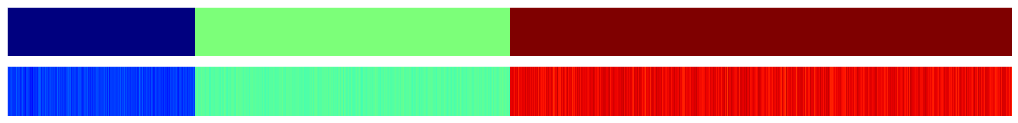

[[ 597086  339095       0]
 [ 139716 1423215       0]
 [   1633  475022 2021233]]
0.8087920752451471


In [7]:
perm_hmmlearn = find_permutation(Z_hat_hmmlearn, Z)
make_plots(Z, perm_hmmlearn[Z_hat_hmmlearn])

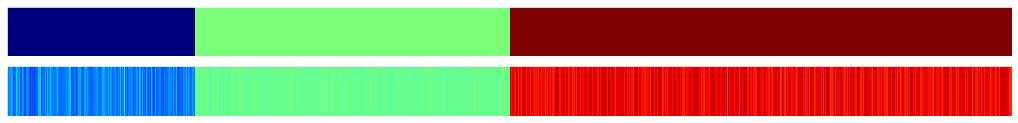

[[ 539428  324718   72035]
 [  98147 1439706   25078]
 [  24307  429750 2043831]]
0.8050760456273764


In [8]:
switch = np.arange(Z_hat_hmmlearn[1:].shape[0])[Z_hat_hmmlearn[1:] != Z_hat_hmmlearn[:-1]] + 1
switch = np.concatenate([np.array([0]), switch])
real_switch = np.concatenate([np.array([0]), switch[1:][(switch[1:] - switch[:-1]) > 3], np.array([Z_hat_hmmlearn.shape[0]])])
Z_hat_post = np.concatenate([(np.bincount(Z_hat_hmmlearn[real_switch[i]:real_switch[i + 1]]).argmax() * np.ones(
    Z_hat_hmmlearn[real_switch[i]:real_switch[i + 1]].shape[0])).astype(int) for i in range(real_switch.shape[0] - 1)])
perm = find_permutation(Z_hat_post, Z)
make_plots(Z, perm[Z_hat_post])

## Gaussian Dense HMM

In [9]:
from models_gaussian_2d import GaussianDenseHMM
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier

2022-12-04 20:23:56.786260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 20:23:58.413925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-04 20:23:58.413987: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-04 20:24:07.276908: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

Instructions for updating:
non-resource variables are not supported in the long term


In [10]:
def compute_stationary(M, verbose=True):
    eigval, eigvec = np.linalg.eig(M.T)
    idx = np.asarray(np.isclose(eigval, [1.], rtol=1e-2, atol=1e-3)).nonzero()[0]
    if idx.size < 1:
        raise Exception("No Eigenvalue 1")
    elif idx.size > 1 and verbose:
        print("Warning: Multiple vectors corresponding to eigenvalue 1.: %s" % str(idx))
    M_stationary = eigvec[:, idx[0]].real
    M_stationary = M_stationary / np.sum(M_stationary)
    return M_stationary

def relu(x):
    return x * (x > 0)

def compute_loss(nodes, splits, n_, omega_gt, means_, covars_, A_):
    B_scalars = None
    if d == 1:  # popraw wizualnie
        B_scalars_tmp = .5 * (
                1 + erf((nodes - np.transpose(a=means_)) / (
                relu(np.transpose(a=covars_[:, :, 0])) + 1e-10) / np.sqrt(2)))

        B_scalars = np.transpose(a=B_scalars_tmp[1:, :] - B_scalars_tmp[:-1, :])
    if d == 2:
        B_scalars_tmp = np.prod(.5 * (
                1 + erf((np.expand_dims(nodes, axis=-1) - np.expand_dims(
            np.transpose(a=means_), axis=0)) / (
                                relu(np.expand_dims(np.transpose(np.array(list(map(lambda x: np.diag(np.array(x)), covars_.tolist())))), axis=0)) + 1e-10) / np.sqrt(2))), axis=1)

        # B_scalars_tmp = np.prod(input_tensor=.5 * (
        #                     1 + erf((np.expand_dims(nodes, axis=-1) - np.expand_dims(
        #                 np.transpose(means_), axis=0)) / (relu(np.expand_dims(np.transpose(covars_),
        #                                                                       axis=0)) + 1e-10) / np.sqrt(2))), axis=1)

            # np.prod(.5 * (
            #     1 + erf((np.expand_dims(nodes, axis=-1) - np.expand_dims(np.transpose(a=means_), axis=0)) /
            #             (relu(np.expand_dims(np.transpose(np.array(list(map(lambda x: np.diag(np.array(x)), covars_.tolist())))), axis=0)) + 1e-10) /
            #             np.sqrt(2))), axis=1)
        B_scalars_tmp_wide = np.reshape(B_scalars_tmp, (*[n.shape[0] for n in splits], n_))
        B_scalars = np.transpose(a=np.reshape(
            B_scalars_tmp_wide[:-1, 1:, :] - B_scalars_tmp_wide[:-1, :-1, :] - B_scalars_tmp_wide[1:, 1:,
                                                                               :] + B_scalars_tmp_wide[1:, :-1, :],
            (-1, n_)))

    A_stationary = compute_stationary(A_, verbose=False)

    theta = A_ * A_stationary[:, None]
    omega = np.matmul(np.transpose(a=B_scalars), np.matmul(theta, B_scalars))
    loss_cooc = np.sum(np.abs(omega_gt - omega)) / 2
    return loss_cooc

def provide_nodes(n_, Y_train):
    kmeans = KMeans(n_).fit(Y_train)
    dtree = DecisionTreeClassifier().fit(Y_train, kmeans.labels_)

    splits = np.concatenate([dtree.tree_.feature.reshape(-1, 1), dtree.tree_.threshold.reshape(-1, 1)], axis=1)
    splits = np.concatenate([splits, np.array([[i, fun(Y_train[:, i])] for i, fun in itertools.product(range(Y_train.shape[1]), [
        lambda x: np.min(x) - 1e-3, lambda x: np.max(x) + 1e-3])])])
    splits = splits[splits[:, 0] >= 0]

    nodes_x = [np.sort(splits[splits[:, 0] == float(i), 1]) for i in np.unique(splits[:, 0])]
    nodes = np.array([t for t in itertools.product(*nodes_x)])

    splits = nodes_x  # number  of splits  on each axis
    discrete_nodes = nodes.astype('float32')
    discrete_observables = [n.shape[0] - 1 for n in nodes_x]

    indexes = np.arange(np.prod(discrete_observables)).reshape(discrete_observables)  # .transpose()
    Y_train_disc = np.array([indexes[i] for i in
                       zip(*[(Y_train[:, j].reshape(-1, 1) > splits[j].reshape(1, -1)).sum(axis=1) - 1 for j in
                             range(len(splits))])])

    return nodes, nodes_x, Y_train_disc

def _lengths_iterator(seqs, lengths):
    n_seqs = len(lengths)
    left, right = 0, 0

    for i in range(len(lengths)):
        right += lengths[i]
        yield seqs[left:right]
        left += lengths[i]

def empirical_coocs(seqs, m, lengths=None):
    freqs = np.zeros((m, m))
    seq_iterator = seqs
    if lengths is not None:
        seq_iterator = _lengths_iterator(seqs, lengths)

    for seq in seq_iterator:

        if seq.shape[0] <= 1:  # no transitions
            continue

        seq = seq.reshape(-1)

        seq_pairs = np.dstack((seq[:-1], seq[1:]))
        seq_pairs, counts = np.unique(seq_pairs, return_counts=True, axis=1)
        seq_pre, seq_suc = [arr.flatten() for arr in np.dsplit(seq_pairs, 2)]
        freqs[seq_pre, seq_suc] += counts

    return freqs, freqs / np.sum(freqs)

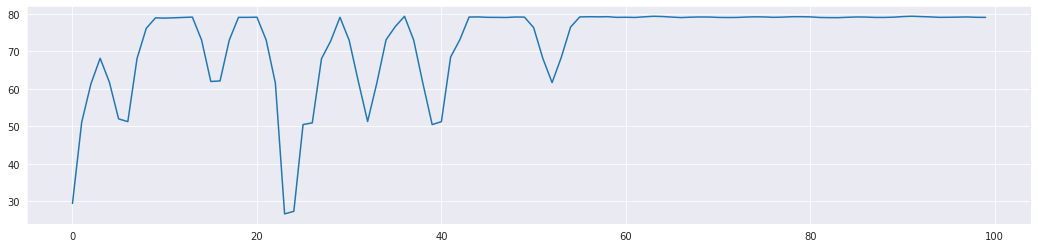

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2022-12-04 20:25:04.252444: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-04 20:25:04.252533: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-04 20:25:04.252580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cymestmp): /proc/driver/nvidia/version does not exist
2022-12-04 20:25:04.256101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 20:25:04.365418: I tensorflow/compiler/mlir/mlir_graph_optimizat

1.1646859506191525


         2   -52811863.4723     +254948.8954


1.0812267038783383


         3   -52498257.2566     +313606.2157


0.4762846559246383


         4   -53183502.9396     -685245.6830


0.13295818090848313


         5   -53409438.5999     -225935.6603


0.09511095872247997


         6   -53017868.2473     +391570.3526


0.08718249743310597


         7   -52352194.3699     +665673.8774


0.08337504455550464


         8   -51610085.4084     +742108.9615


0.08019191874701091


         9   -50881487.1757     +728598.2327


0.0771270785392644


        10   -50203194.6645     +678292.5112


0.07405795438438338


        11   -49588072.6138     +615122.0508


0.07091238780725213


        12   -49038366.7816     +549705.8321


0.06764059780506336


        13   -48551359.8504     +487006.9312


0.06420728972746557


        14   -48122008.0788     +429351.7716


0.060579570325781415


        15   -47744512.6085     +377495.4702


0.05671658653054335


        16   -47413460.5119     +331052.0966


0.05256514844440744


        17   -47124706.7691     +288753.7428


0.04806414769853819


        18   -46876015.6892     +248691.0799


0.04316135663835546


        19   -46667361.5601     +208654.1291


0.037846373960224076


        20   -46500653.0556     +166708.5045


0.03219773126500131


        21   -46378630.4826     +122022.5730


0.026424678703343148


        22   -46303026.1562      +75604.3264


0.020861882479515502


        23   -46272738.4465      +30287.7097


0.015883240294497652


        24   -46283082.9602      -10344.5136


0.011766580139367454


        25   -46326537.3040      -43454.3438


0.008603356806111065


        26   -46394365.4926      -67828.1887


0.006311686525376727


        27   -46478177.9820      -83812.4893


0.004717219191364646


        28   -46570908.1034      -92730.1214


0.0036322118444689546


        29   -46667182.2181      -96274.1147


0.002898616660755862


        30   -46763276.2852      -96094.0670


0.002399405647957016


        31   -46856860.1312      -93583.8461


0.002053908558023396


        32   -46946672.1556      -89812.0244


0.001808661031094305


        33   -47032207.2047      -85535.0491


0.001628939586025193


        34   -47113455.9301      -81248.7254


0.0014923949049039154


        35   -47190706.0028      -77250.0727


0.0013846781317253948


        36   -47264400.6834      -73694.6806


0.001296564884427633
147.4525225162506


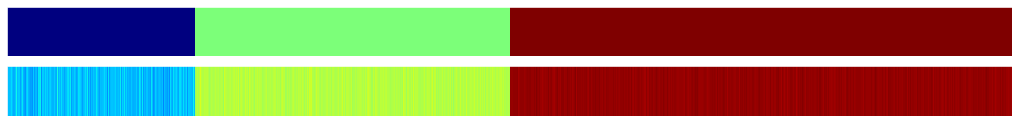

[[ 458191  365425  112565]
 [      0 1342466  220465]
 [      0  100243 2397645]]
0.8401644986992195


In [11]:
f = gzip.open('data_hmm_004b.pcklz', 'rb')
X = pickle.load(f)
Z = pickle.load(f)
f.close()

plt.figure(figsize=(18,4))
plt.plot(X[:100])
plt.show()

n = 3
d = 1
Y = X
lengths = np.array([Y.shape[0]])

nodes, splits, Y_disc = provide_nodes(n, Y)
_, omega_gt = empirical_coocs(Y_disc.reshape(-1, 1), np.max(Y_disc) + 1, lengths=lengths)
model = GaussianDenseHMM(n_hidden_states=n, mstep_config={'cooc_epochs': 12000 * n, 'cooc_lr': 0.003, 'loss_type': 'square'}, n_dims=d,
                         verbose=True, early_stopping=True, convergence_tol=0.0001, covariance_type='diag')
t0 = time.time()
model.fit_coocs(Y, lengths=L)
print(time.time() - t0)
Z_hat = model.predict(Y, L)

perm = find_permutation(Z_hat, Z)
make_plots(Z, perm[Z_hat])

In [12]:
model.score(Y, lengths=L)

-47334974.88569065

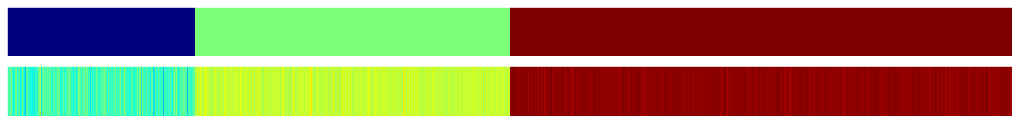

[[ 340847  377598  217736]
 [   5734 1266672  290525]
 [   7367   60448 2430073]]
0.8080032019211527


In [13]:
switch = np.arange(Z_hat[1:].shape[0])[Z_hat[1:] != Z_hat[:-1]] + 1
switch = np.concatenate([np.array([0]), switch])
real_switch = np.concatenate([np.array([0]), switch[1:][(switch[1:] - switch[:-1]) > 3], np.array([Z_hat.shape[0]])])
Z_hat_post = np.concatenate([(np.bincount(Z_hat[real_switch[i]:real_switch[i + 1]]).argmax() * np.ones(
    Z_hat[real_switch[i]:real_switch[i + 1]].shape[0])).astype(int) for i in range(real_switch.shape[0] - 1)])
perm = find_permutation(Z_hat_post, Z)
make_plots(Z, perm[Z_hat_post])

In [14]:
def make_plots2(Z, Z_hat, Z_hat2):
    order = Z.argsort()

    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,2), sharey=True)
    ax1.imshow(Z[order].reshape(1, -1), aspect="auto", extent=(-0.5, Z.shape[0] - 0.5, 0, 1), cmap="rainbow")
    ax1.set_xticks([])
    # plt.sca(ax1)
    ax2.set_yticks([])
    ax1.set_ylabel("Ground Truth", rotation=0, ha='right')

    ax2.imshow(Z_hat[order].reshape(1, -1), aspect="auto", extent=(-0.5, Z_hat.shape[0] - 0.5, 0, 1), cmap="rainbow")
    ax2.set_xticks([])
    # plt.sca(ax2)
    ax2.set_yticks([])
    ax2.set_ylabel("Standard Gaussian HMM", rotation=0, ha='right')

    ax3.imshow(Z_hat2[order].reshape(1, -1), aspect="auto", extent=(-0.5, Z_hat2.shape[0] - 0.5, 0, 1), cmap="rainbow")
    ax3.set_xticks([])
    # plt.sca(ax3)
    ax2.set_yticks([])
    ax3.set_ylabel("Gaussian Dense HMM", rotation=0, ha='right')
    plt.suptitle("Overall Consistency of the States")
    plt.show()

    cm = confusion_matrix(Z_hat2, Z_hat)

    cm_best_ = cm.copy()
    cm_best_a_ = np.diag(cm_best_).sum()
    for p in itertools.permutations(np.arange(cm.shape[0])):
        cm_ = cm[p, :].copy()
        cm_a_ = np.diag(cm_).sum()
        if cm_a_ > cm_best_a_:
            cm_best_ = cm_.copy()
            cm_best_a_ = cm_a_
    print(cm_best_)
    print(cm_best_a_ / cm_best_.sum())

In [15]:
perm = find_permutation(Z_hat, Z)

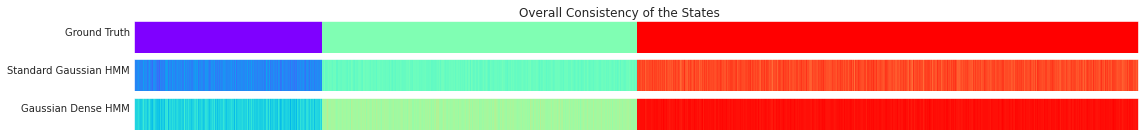

[[ 458191       0       0]
 [ 280244 1527890       0]
 [      0  709442 2021233]]
0.8019439663798279


In [16]:
make_plots2(Z, perm_hmmlearn[Z_hat_hmmlearn], perm[Z_hat])

In [17]:
print((Z == perm_hmmlearn[Z_hat_hmmlearn])[Z == 0].mean())
print((Z != perm_hmmlearn[Z_hat_hmmlearn])[perm_hmmlearn[Z_hat_hmmlearn] != 0].mean())

0.6377890600215129
0.19117167402634455


In [18]:
print((Z == perm_hmmlearn[Z_hat_hmmlearn])[Z == 1].mean())
print((Z != perm_hmmlearn[Z_hat_hmmlearn])[perm_hmmlearn[Z_hat_hmmlearn] != 1].mean())

0.9106064183255691
0.05121956699139172


In [19]:
print((Z == perm_hmmlearn[Z_hat_hmmlearn])[Z == 2].mean())
print((Z != perm_hmmlearn[Z_hat_hmmlearn])[perm_hmmlearn[Z_hat_hmmlearn] != 2].mean())

0.8091767925543499
0.32108226215291724


In [20]:
print((Z == perm[Z_hat])[Z == 0].mean())
print((Z != perm[Z_hat])[perm[Z_hat] != 0].mean())
print((Z == perm[Z_hat])[Z == 1].mean())
print((Z != perm[Z_hat])[perm[Z_hat] != 1].mean())
print((Z == perm[Z_hat])[Z == 2].mean())
print((Z != perm[Z_hat])[perm[Z_hat] != 2].mean())

0.4894256559361918
0.17597083287708296
0.8589413096291519
0.10443524437840913
0.9598688972443921
0.20547273669928187


In [28]:
print((Z == perm_hmmlearn[Z_hat_hmmlearn])[Z == 0].mean())
print(((Z != 0) == (perm_hmmlearn[Z_hat_hmmlearn] != 0))[Z != 0].mean())
print((Z == perm_hmmlearn[Z_hat_hmmlearn])[Z == 1].mean())
print(((Z != 1) == (perm_hmmlearn[Z_hat_hmmlearn] != 1))[Z != 1].mean())
print((Z == perm_hmmlearn[Z_hat_hmmlearn])[Z == 2].mean())
print(((Z != 2) == (perm_hmmlearn[Z_hat_hmmlearn] != 2))[Z != 2].mean())
print((Z == perm[Z_hat])[Z == 0].mean())
print(((Z != 0) == (perm[Z_hat] != 0))[Z != 0].mean())
print((Z == perm[Z_hat])[Z == 1].mean())
print(((Z != 1) == (perm[Z_hat] != 1))[Z != 1].mean())
print((Z == perm[Z_hat])[Z == 2].mean())
print(((Z != 2) == (perm[Z_hat] != 2))[Z != 2].mean())

0.6377890600215129
0.9651919969838597
0.9106064183255691
0.7629293412566841
0.8091767925543499
1.0
0.4894256559361918
1.0
0.8589413096291519
0.8643975994658232
0.9598688972443921
0.8667406662846643


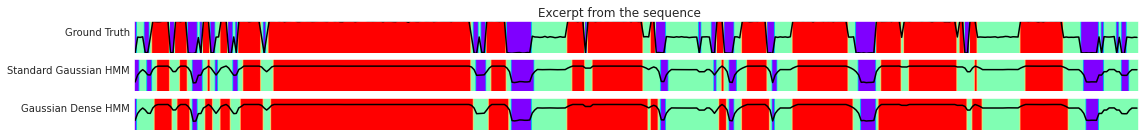

In [27]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,2), sharey=True)
ax1.plot(X_[3:400], color='Black')
ax1.imshow(Z[:397].reshape(1, -1), aspect="auto", extent=(-0.5, Z[:397].shape[0] - 0.5, 0, 110), cmap="rainbow")
ax1.set_xticks([])
# plt.sca(ax1)
ax2.set_yticks([])
ax1.set_ylabel("Ground Truth", rotation=0, ha='right')

ax2.plot(X[:397], color='Black')
ax2.imshow(perm_hmmlearn[Z_hat_hmmlearn][:397].reshape(1, -1), aspect="auto", extent=(-0.5, Z_hat_hmmlearn[3:400].shape[0] - 0.5, 0, 100), cmap="rainbow")
ax2.set_xticks([])
# plt.sca(ax2)
ax2.set_yticks([])
ax2.set_ylabel("Standard Gaussian HMM", rotation=0, ha='right')

ax3.plot(X[:397], color='Black')
ax3.imshow(perm[Z_hat][:397].reshape(1, -1), aspect="auto", extent=(-0.5, Z_hat[3:400].shape[0] - 0.5, 0, 100), cmap="rainbow")
ax3.set_xticks([])
# plt.sca(ax3)
ax2.set_yticks([])
ax3.set_ylabel("Gaussian Dense HMM", rotation=0, ha='right')
plt.suptitle("Excerpt from the sequence")
plt.show()

In [22]:
X_.max()

104.85645032819141

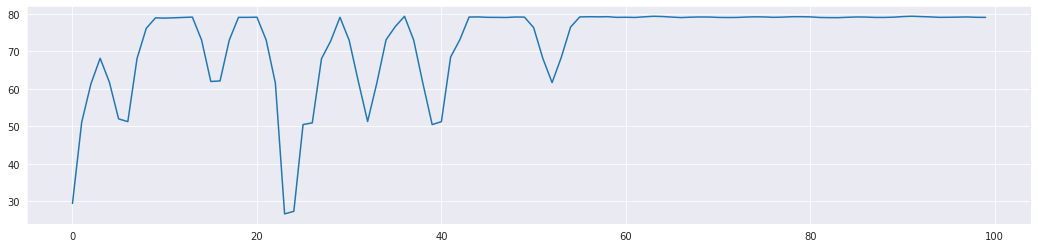

         1   -49432741.4742             +nan


0.0862182840341168


         2   -49174708.4177     +258033.0566


0.0447210841948917


         3   -48838030.5996     +336677.8181


0.03613891641219904


         4   -48484354.7502     +353675.8493


0.029852276754076618


         5   -48181072.2096     +303282.5406


0.024576066130924


         6   -47936433.0757     +244639.1340


0.020320843680787577


         7   -47742177.4582     +194255.6174


0.016959241897587952


         8   -47587970.5717     +154206.8866


0.014325303403740865


         9   -47464840.4537     +123130.1179


0.012268846896958951


        10   -47365633.5671      +99206.8866


0.010665442386687913


        11   -47284798.9697      +80834.5974


0.00941475141815108


        12   -47218077.8172      +66721.1525


0.008437054263903156


        13   -47162223.3245      +55854.4927


0.007669815501560305


        14   -47114770.4066      +47452.9178


0.007064518040232904


        15   -47073852.0639      +40918.3427


0.006583834797399241


        16   -47038055.6569      +35796.4070


0.006199201001422829


        17   -47006311.9663      +31743.6907


0.005888811831575085


        18   -46977810.5068      +28501.4594


0.005636024423858773


        19   -46951935.4235      +25875.0833


0.005428113460498496


        20   -46928217.2487      +23718.1749


0.005255318353052974


        21   -46906296.7260      +21920.5227


0.005110121523926535


        22   -46885897.7311      +20398.9949


0.0049867050760779566


        23   -46866807.0068      +19090.7243


0.004880542853035092


        24   -46848858.9872      +17948.0196


0.004788094206828579


        25   -46831924.4151      +16934.5722


0.00470657374829918


        26   -46815901.7860      +16022.6291


0.004633777735369528


        27   -46800710.9018      +15190.8841


0.004567952685326523


        28   -46786288.0004      +14422.9014


0.004507695521455409


        29   -46772582.0644      +13705.9360


0.0044518773395388215


        30   -46759552.0168      +13030.0476


0.004399584931768176
156.58508563041687


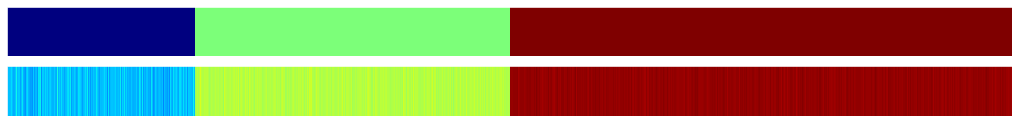

[[ 458191  365425  112565]
 [      0 1342466  220465]
 [      0  100243 2397645]]
0.8401644986992195


In [24]:
f = gzip.open('data_hmm_004b.pcklz', 'rb')
X = pickle.load(f)
Z = pickle.load(f)
f.close()

plt.figure(figsize=(18,4))
plt.plot(X[:100])
plt.show()

n = 3
d = 1
Y = X
lengths = np.array([Y.shape[0]])

nodes, splits, Y_disc = provide_nodes(n, Y)
_, omega_gt = empirical_coocs(Y_disc.reshape(-1, 1), np.max(Y_disc) + 1, lengths=lengths)
model2 = GaussianDenseHMM(n_hidden_states=n, mstep_config={'cooc_epochs': 10000 * n, 'cooc_lr': 0.002, 'loss_type': 'square'}, n_dims=d,
                         verbose=True, early_stopping=True, convergence_tol=0.0001, covariance_type='diag')
t0 = time.time()
model2.fit_coocs(Y, lengths=L)
print(time.time() - t0)
Z_hat2 = model2.predict(Y, L)

perm2 = find_permutation(Z_hat2, Z)
make_plots(Z, perm2[Z_hat2])